In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

Пример без лагов

In [30]:
# Создаем синтетические данные
np.random.seed(50)
n_samples = 10000

# Рейтинги (пример порядка)
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']
company_types = ['bank', 'oil', 'tech', 'retail', 'telecom']

data = pd.DataFrame({
    'rating': np.random.choice(ratings, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_samples, freq='D'),
    'company_type': np.random.choice(company_types, size=n_samples),
    'inn': np.random.randint(1000,2000, size=n_samples)  # просто случайные ИНН
})

In [32]:
# ① Кодируем рейтинг (ординально, если есть порядок)
rating_order = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']  # от лучшего к худшему
encoder = OrdinalEncoder(categories=[rating_order])
data['rating_encoded'] = encoder.fit_transform(data[['rating']])

# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# ③ Категориальные фичи (One-Hot для типа компании)
data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')

# Удаляем ненужные столбцы
data = data.drop(['inn', 'date'], axis=1)

In [34]:
# Фичи и целевая переменная
X = data.drop(['rating', 'rating_encoded'], axis=1)
y = data['rating_encoded']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=rating_order))

Accuracy: 0.11
              precision    recall  f1-score   support

         AAA       0.10      0.11      0.11       298
         AA+       0.11      0.12      0.11       310
          AA       0.17      0.15      0.16       337
         BBB       0.14      0.13      0.13       372
         BB+       0.12      0.13      0.13       344
          BB       0.08      0.08      0.08       346
           B       0.09      0.10      0.10       317
         CCC       0.11      0.10      0.10       347
           D       0.11      0.10      0.10       329

    accuracy                           0.11      3000
   macro avg       0.11      0.11      0.11      3000
weighted avg       0.11      0.11      0.11      3000



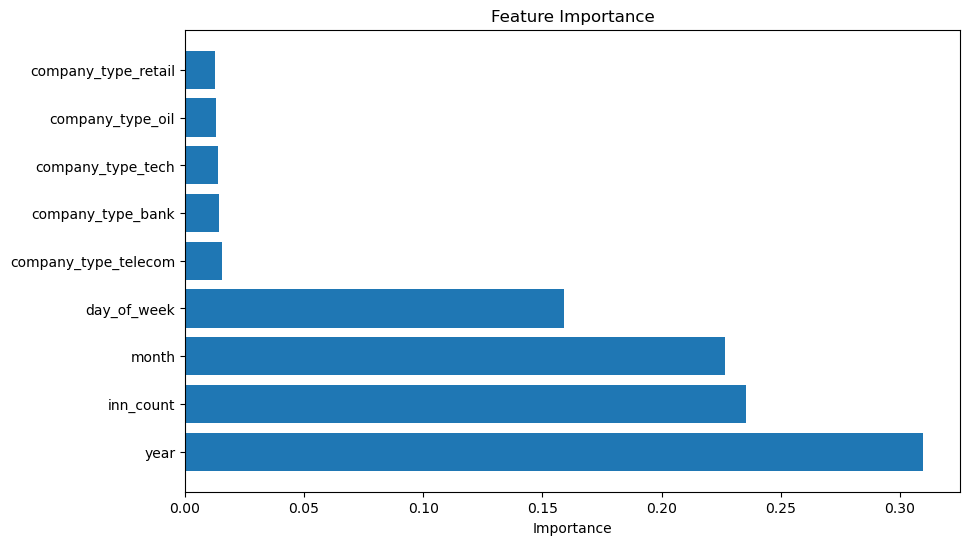

In [35]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Пример с лагами

In [39]:
np.random.seed(42)
n_companies = 500  # 50 компаний
n_months = 24     # 2 года данных (24 месяца)
n_samples = 10000
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
data = pd.DataFrame({
    'inn': np.random.randint(1000,2000, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_months, freq='ME').tolist() * n_companies,
    'rating': np.random.choice(ratings, size=n_companies * n_months, p=[0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02])
})
print(data['inn'].unique())

ValueError: All arrays must be of the same length

In [41]:
np.random.seed(42)
n_companies = 5000
n_months = 24
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
rating_probs = [0.1, 0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1]

# Создаем компании с разными характеристиками
companies = pd.DataFrame({
    'inn': np.random.randint(1000, 2000, size=n_companies),
    'company_type': np.random.choice(['bank', 'oil', 'tech', 'retail', 'manufacturing'], size=n_companies),
    'base_rating': np.random.choice(ratings, size=n_companies, p=rating_probs)
})

# Генерируем временные ряды для каждой компании
data = []
for _, company in companies.iterrows():
    dates = pd.date_range(start='2020-01-01', periods=n_months, freq='ME')
    base_rating_idx = ratings.index(company['base_rating'])
    
    # Генерируем рейтинги с некоторой динамикой
    rating_idxs = np.clip(
        base_rating_idx + np.cumsum(np.random.normal(0, 0.3, n_months)).round().astype(int),
        0, len(ratings)-1
    )
    company_ratings = [ratings[i] for i in rating_idxs]
    
    data.extend([{
        'inn': company['inn'],
        'date': date,
        # 'company_type': company['company_type'],
        'rating': rating,
        'months_since_start': i
    } for i, (date, rating) in enumerate(zip(dates, company_ratings))])

data = pd.DataFrame(data)

In [42]:
# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# # ③ Категориальные фичи (One-Hot для типа компании)
# data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')


In [58]:
# --- 2. Добавляем лаги рейтинга ---
data = data.sort_values(['inn', 'date'])

for lag in [1, 3, 6, 12]:
    data[f'rating_lag_{lag}'] = data.groupby('inn')['rating'].shift(lag)

# Удаляем строки с NaN (где нет истории)
data = data.dropna()


In [60]:
# --- 3. Правильное кодирование ---
# Создаем словарь для ручного кодирования
rating_to_code = {rating: i for i, rating in enumerate(rating_order)}

# Применяем кодирование ко всем столбцам с рейтингами
data['rating_encoded'] = data['rating'].map(rating_to_code)
for lag in [1, 3, 6, 12]:
    col = f'rating_lag_{lag}'
    data[col] = data[col].map(rating_to_code)
# Разница с предыдущим рейтингом
data['rating_diff_1'] = data.groupby('inn')['rating_encoded'].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby('inn')['rating_encoded'].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby('inn')['rating_encoded'].diff(3).fillna(0)
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())

[ 0. -1.  3.  2. -3. -2.  4.  1.  7. -4.  5. -6. -5.  6. -7.]
[ 0. -1.  2.  5. -3. -2.  1.  4.  3. -5.  6. -4. -6. -7.  7.]
[ 0. -2.  2.  4. -1. -5.  3.  5. -6.  1.  6. -4. -3. -7.  7.]


In [62]:
data.dropna()

,inn,date,rating,months_since_start,year,month,day_of_week,inn_count,rating_encoded,rating_diff_1,rating_diff_2,rating_diff_3,rating_lag_1,rating_lag_3,rating_lag_6,rating_lag_12
38041,1000,2020-02-29,BBB,1,2020,2,5,216,3,0.0,0.0,0.0,1,3,1,3
66241,1000,2020-02-29,AA,1,2020,2,5,216,2,-1.0,0.0,0.0,3,3,4,3
68137,1000,2020-02-29,AA,1,2020,2,5,216,2,0.0,-1.0,0.0,2,1,6,1
101617,1000,2020-02-29,AA+,1,2020,2,5,216,1,-1.0,-1.0,-2.0,2,3,3,3
108265,1000,2020-02-29,BB+,1,2020,2,5,216,4,3.0,2.0,2.0,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89803,1999,2021-08-31,BBB,19,2021,8,1,24,3,1.0,1.0,1.0,2,2,2,1
89804,1999,2021-09-30,BBB,20,2021,9,3,24,3,0.0,1.0,1.0,3,2,2,2
89805,1999,2021-10-31,BBB,21,2021,10,6,24,3,0.0,0.0,1.0,3,2,2,2
89806,1999,2021-11-30,BBB,22,2021,11,1,24,3,0.0,0.0,0.0,3,3,2,2


In [64]:
# --- 4. Фичи и обучение ---
# X = data.filter(like='lag_')  # Только лаги
# y = data['rating_encoded']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)
exclude_cols = ['inn', 'date', 'rating', 'rating_encoded']
X = data.drop(exclude_cols, axis=1)
y = data['rating_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Обучение модели ---
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    # class_weight='balanced'  # Для несбалансированных данных
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [65]:
# --- 5. Оценка ---
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro'):.2f}")
# print(classification_report(y_test, y_pred, target_names=rating_order))

# Важность фичей
# pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values('importance', ascending=False)

Accuracy: 0.94
Recall: 0.94
Precision: 0.94
F1 score: 0.94


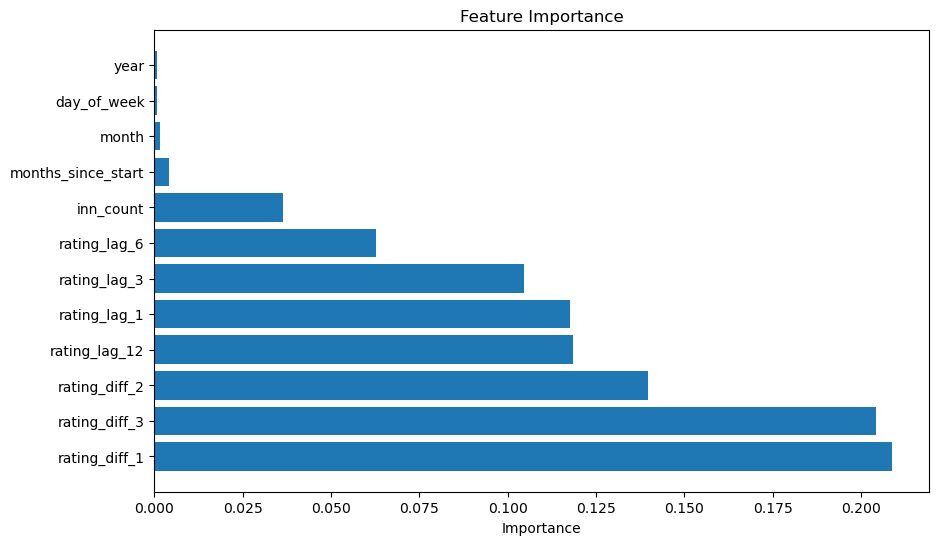

In [66]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

А теперь на реальных данных с подуровнем

In [252]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [254]:
data = pd.read_excel("/Users/danilalipatov/PycharmProjects/diploma/resemple_data_cat_level_cat.xlsx")

In [255]:
inn = 'identifier'
date = 'resampled_dates'
num_ = 'resampled_values'
category = 'rating_category'
agency = 'agency'
_ro_type = '_ro_type'
current_agency = 'Expert_RA'
current_ro_type = 'BNFC - нефинансовая компания'
print(data["_ro_type"].unique())
print(len(data[inn].unique()))

['BNFC - нефинансовая компания' 'CBNK - кредитная организация'
 'FLSG - лизинговая компания (фирма)'
 'FOFO - прочие финансовые организации, в том числе специализированные общества'
 'CO - прочий вид организации' 'FNPF - негосударственный пенсионный фонд'
 'FINS - страховая организация'
 'BNFH - холдинговая компания (нефинансовая)'
 'FMFO - микрофинансовая организация' 'FDEP - депозитарий'
 'FFCT - юридическое лицо, специализирующееся на предоставлении финансирования под уступку денежного требования (факторинговая компания)'
 'IFO - международная финансовая организация']
1302


In [256]:
# ручной фильтр
# data[(data[agency] == current_agency) & (data[_ro_type] == current_ro_type)]

In [257]:
# --- Предобработка ---
data[date] = pd.to_datetime(data[date])
data = data.sort_values([inn, date])

# Лаги
data['rating_diff_1'] = data.groupby(inn)[num_].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby(inn)[num_].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby(inn)[num_].diff(3).fillna(0)
data['rating_diff_4'] = data.groupby(inn)[num_].diff(4).fillna(0)
data['rating_diff_5'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_6'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_7'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_8'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_9'] = data.groupby(inn)[num_].diff(5).fillna(0)

for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 24]:
    data[f'rating_lag_{lag}'] = data.groupby(inn)[num_].shift(lag).dropna()
    print(f'rating_lag_{lag}')
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())
# Временные признаки
data['year'] = data[date].dt.year
data['month'] = data[date].dt.month
data['day_of_week'] = data[date].dt.dayofweek

# Метки
data['inn_count'] = data.groupby(inn)[inn].transform('count')

# Возраст компании
first_seen = data.groupby(inn)[date].transform('min')
data['company_age_months'] = ((data[date] - first_seen) / np.timedelta64(1, 'm')).astype(int)

# --- Подготовка признаков ---
categorical_features = [agency, _ro_type]
numerical_features = [
    'year', 'month', 'day_of_week',
    'inn_count', 'company_age_months', 
    # 'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4', 'rating_diff_5', 'rating_diff_6',
    'rating_lag_1', 'rating_lag_2', 'rating_lag_3', 'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7', 'rating_lag_8', 'rating_lag_9', 'rating_lag_12', 'rating_lag_24'
]

features = categorical_features + numerical_features
# features = numerical_features
# Удалим пропуски
data = data.dropna(subset=features + [num_])

X = data[features]
y = data[num_].astype(int)

rating_lag_1
rating_lag_2
rating_lag_3
rating_lag_4
rating_lag_5
rating_lag_6
rating_lag_7
rating_lag_8
rating_lag_9
rating_lag_12
rating_lag_24
[  0.   1.  -2.   2.  -1.   3.   7.   4.   5. -11.  -3.  11.   6.   8.
 -19. -10.  -8.  -7.  -9.   9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14.  14.  15. -18.]
[  0.   1.  -2.  -1.   3.   2.   7.   4.   5. -11.   9.  11.   6.  -3.
   8. -19. -10.  -8.  -7.  -9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14.  14.  15. -18.]
[  0.   1.  -2.   2.  -3.  -1.   3.   6.   7.   4.   5. -11.  11.   9.
   8. -19. -10.  -8.  -7.  -9.  -4.  10. -12.  12.  -6.  -5. -13.  13.
 -14. -15.  15. -18.]


In [258]:
len(data[inn].unique())

1090

In [259]:
# --- Pipeline ---
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numerical_features)
])
# preprocessor = ColumnTransformer([
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
#     ('num', 'passthrough', numerical_features)
# ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200))
])

In [291]:
# --- Обучение ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print(X_train.columns, y_train.name)
pipeline.fit(X_train, y_train)

Index(['agency', '_ro_type', 'year', 'month', 'day_of_week', 'inn_count',
       'company_age_months', 'rating_lag_1', 'rating_lag_2', 'rating_lag_3',
       'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7',
       'rating_lag_8', 'rating_lag_9', 'rating_lag_12', 'rating_lag_24'],
      dtype='object') resampled_values


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['agency', '_ro_type']),
                                                 ('num', 'passthrough',
                                                  ['year', 'month',
                                                   'day_of_week', 'inn_count',
                                                   'company_age_months',
                                                   'rating_lag_1',
                                                   'rating_lag_2',
                                                   'rating_lag_3',
                                                   'rating_lag_4',
                                                   'rating_lag_5',
                                                   'rating_lag_6',
                                                   'rating_lag_7',
                                                   'rating_lag_8',
                                                   'rating_lag_9',
                                                   'rating_lag_12',
                                                   'rating_lag_24'])])),
                ('classifier', RandomForestClassifier(n_estimators=200))])

In [292]:
# --- Оценка ---
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
precision_weight = precision_score(y_test, y_pred, average='weighted')
recall_weight = recall_score(y_test, y_pred, average='weighted')
f1_weight = f1_score(y_test, y_pred, average='weighted')
# Выводим метрики
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print(f'Precision_weighted: {precision_weight:.2f}')
print(f'Recall_weighted: {recall_weight:.2f}')
print(f'F1 Score_weighted: {f1_weight:.2f}')

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      1774
           2       0.97      0.96      0.97       587
           3       0.98      0.97      0.98      1062
           4       0.85      0.95      0.89       500
           5       0.93      0.92      0.92      1035
           6       0.95      0.93      0.94      1205
           7       0.95      0.95      0.95      1099
           8       0.95      0.95      0.95       733
           9       0.90      0.94      0.92       622
          10       0.96      0.90      0.93       772
          11       0.98      0.97      0.98       757
          12       0.98      0.99      0.99       734
          13       0.92      0.95      0.93       377
          14       0.92      0.91      0.91       636
          15       0.96      0.94      0.95       682
          16       0.98      0.99      0.98       402
          17       0.97      1.00      0.99        75
          19       0.00    

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

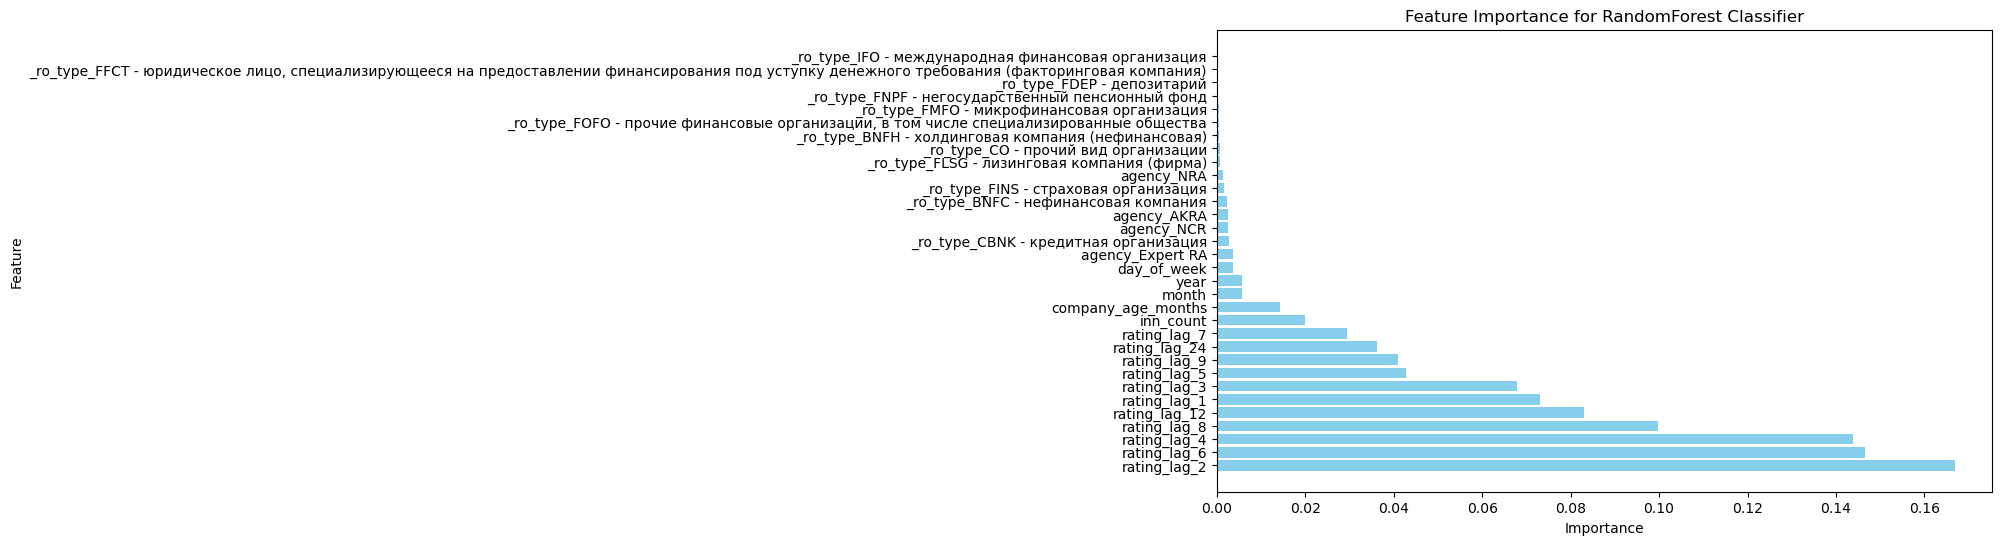

                                              Feature  Importance
22                                       rating_lag_2    0.166879
26                                       rating_lag_6    0.146669
24                                       rating_lag_4    0.143914
28                                       rating_lag_8    0.099750
30                                      rating_lag_12    0.082956
21                                       rating_lag_1    0.073051
23                                       rating_lag_3    0.067876
25                                       rating_lag_5    0.042815
29                                       rating_lag_9    0.041067
31                                      rating_lag_24    0.036276
27                                       rating_lag_7    0.029383
19                                          inn_count    0.019843
20                                 company_age_months    0.014317
17                                              month    0.005674
16        

In [293]:
# Получение важности фичей
# Важно, что для извлечения важности нужно обратиться к "classifier" внутри pipeline
importances = pipeline.named_steps['classifier'].feature_importances_

# Получаем список всех фичей (категориальные и числовые)
all_features = (pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features)
# all_features = numerical_features
# Создание DataFrame для отображения важности фичей
feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Сортировка фичей по важности
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# --- График важности фичей ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForest Classifier')
plt.show()

# Выводим важность фичей
print(feature_importances)

In [294]:
len(data[inn].unique())

1090

Предсказания:

In [296]:
def predict_next_rating(model, last_rows: pd.DataFrame) -> int:
    # Сортировка по дате
    last_rows = last_rows.sort_values("resampled_dates")
    
    # Вычисление разницы рейтинга
    diffs = last_rows[num_].diff().fillna(0)
    
    # Разница по рейтингу для нескольких периодов
    rating_diff_1 = diffs.iloc[-1]
    rating_diff_2 = diffs.iloc[-2] if len(diffs) > 1 else 0
    rating_diff_3 = diffs.iloc[-3] if len(diffs) > 2 else 0
    rating_diff_4 = diffs.iloc[-4] if len(diffs) > 3 else 0
    rating_diff_5 = diffs.iloc[-5] if len(diffs) > 4 else 0
    rating_diff_6 = diffs.iloc[-6] if len(diffs) > 5 else 0
    rating_diff_7 = diffs.iloc[-7] if len(diffs) > 6 else 0
    rating_diff_8 = diffs.iloc[-8] if len(diffs) > 7 else 0
    rating_diff_9 = diffs.iloc[-9] if len(diffs) > 8 else 0
    
    last_date = pd.to_datetime(last_rows["resampled_dates"].iloc[-1])
    start_date = pd.to_datetime(last_rows["resampled_dates"].min())
    year = last_date.year
    month = last_date.month + 1 if last_date.month < 12 else 1
    day_of_week = (last_date + pd.DateOffset(months=1)).dayofweek

    # Вычисление возраста компании
    company_age = (last_date.year - start_date.year) * 12 + (last_date.month - start_date.month)

    # Вычисление месяцев с начала
    months_since_start = company_age  # Это можно доработать, если нужна более точная формула

    # Лаги рейтинга
    rating_lag_1 = last_rows[num_].iloc[-2] if len(last_rows) > 1 else 0
    rating_lag_2 = last_rows[num_].iloc[-3] if len(last_rows) > 1 else 0
    rating_lag_3 = last_rows[num_].iloc[-4] if len(last_rows) > 3 else 0
    rating_lag_4 = last_rows[num_].iloc[-5] if len(last_rows) > 1 else 0
    rating_lag_5 = last_rows[num_].iloc[-6] if len(last_rows) > 1 else 0
    rating_lag_6 = last_rows[num_].iloc[-7] if len(last_rows) > 6 else 0
    rating_lag_7 = last_rows[num_].iloc[-8] if len(last_rows) > 1 else 0
    rating_lag_8 = last_rows[num_].iloc[-9] if len(last_rows) > 1 else 0
    rating_lag_9 = last_rows[num_].iloc[-10] if len(last_rows) > 9 else 0
    rating_lag_12 = last_rows[num_].iloc[-13] if len(last_rows) > 12 else 0
    rating_lag_24 = last_rows[num_].iloc[-25] if len(last_rows) > 24 else 0
    # Дополнительная информация
    inn_count = len(last_rows)
    row = last_rows.iloc[-1]
    
    # Создание входных данных для модели
    input_data = pd.DataFrame([{
        # 'rating_diff_1': rating_diff_1,
        # 'rating_diff_2': rating_diff_2,
        # 'rating_diff_3': rating_diff_3,
        # 'rating_diff_4': rating_diff_4,
        # 'rating_diff_5': rating_diff_5,
        # 'rating_diff_6': rating_diff_6,
        # 'rating_diff_7': rating_diff_7,
        # 'rating_diff_8': rating_diff_8,
        # 'rating_diff_9': rating_diff_9,
        'year': year,
        'month': month,
        'day_of_week': day_of_week,
        'inn_count': inn_count,
        'company_age_months': company_age,  # Возраст компании
        'rating_lag_1': rating_lag_1,
        'rating_lag_2': rating_lag_2,
        'rating_lag_3':rating_lag_3,
        'rating_lag_4': rating_lag_4,
        'rating_lag_5': rating_lag_5,
        'rating_lag_6':rating_lag_6,
        'rating_lag_7': rating_lag_7,
        'rating_lag_8': rating_lag_8,
        'rating_lag_9':rating_lag_9,
        'rating_lag_12': rating_lag_12,
        'rating_lag_24':rating_lag_24,
        agency: row[agency],
        _ro_type: row[_ro_type]  # Добавление _ro_type
    }])


    return model.predict(input_data)[0]

In [297]:
def forecast_k_steps(model, last_rows: pd.DataFrame, k: int) -> list:
    predictions = []

    for _ in range(k):
        # Прогноз одного шага
        next_rating = predict_next_rating(model, last_rows)
        predictions.append(next_rating)

        # Обновим временной ряд, чтобы использовать для следующего шага
        last_date = pd.to_datetime(last_rows[date].iloc[-1])
        next_date = last_date + pd.DateOffset(months=1)  # шаг = 1 месяц

        new_row = last_rows.iloc[-1].copy()
        new_row[date] = next_date
        new_row[num_] = next_rating
        last_rows = pd.concat([last_rows, pd.DataFrame([new_row])], ignore_index=True)

    return predictions


In [298]:
import random
company_inn = random.choice(list(data[inn].unique()))  # Пример
last_rows = data[data[inn] == company_inn].drop(columns=['Unnamed: 0', 'rating_category', 'identifier']).tail(24)  # Последние 5 записей для компании
print(last_rows.columns)
last_rows = last_rows.sort_values("resampled_dates")
missing = set(X_test.columns) - set(last_rows.columns)
print(missing)
# input_features = last_rows[X_test.columns]  # только нужные признаки
predicted_rating = predict_next_rating(pipeline, last_rows)
print(f"Прогнозируемый рейтинг для компании {company_inn}: {predicted_rating}")
print(len(data[inn].unique()))

Index(['agency', '_ro_type', 'resampled_dates', 'resampled_values',
       'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4',
       'rating_diff_5', 'rating_diff_6', 'rating_diff_7', 'rating_diff_8',
       'rating_diff_9', 'rating_lag_1', 'rating_lag_2', 'rating_lag_3',
       'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7',
       'rating_lag_8', 'rating_lag_9', 'rating_lag_12', 'rating_lag_24',
       'year', 'month', 'day_of_week', 'inn_count', 'company_age_months'],
      dtype='object')
set()
Прогнозируемый рейтинг для компании 4101011782: 13
1090


In [299]:
forecast_24 = forecast_k_steps(pipeline, last_rows, k=24)

In [300]:
forecast_24

[13,
 12,
 13,
 12,
 12,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

In [301]:
last_rows

,agency,_ro_type,resampled_dates,resampled_values,rating_diff_1,rating_diff_2,rating_diff_3,rating_diff_4,rating_diff_5,rating_diff_6,...,rating_lag_7,rating_lag_8,rating_lag_9,rating_lag_12,rating_lag_24,year,month,day_of_week,inn_count,company_age_months
70566,Expert RA,CBNK - кредитная организация,2023-12-31,13,0.0,0.0,0.0,-1.0,0.0,-1.0,...,13.0,14.0,13.0,14.0,15.0,2023,12,6,99,2894400
70587,NRA,CBNK - кредитная организация,2023-12-31,13,0.0,0.0,0.0,0.0,-1.0,0.0,...,14.0,13.0,14.0,13.0,15.0,2023,12,6,99,2894400
70567,Expert RA,CBNK - кредитная организация,2024-01-31,13,0.0,0.0,0.0,0.0,0.0,-1.0,...,13.0,14.0,13.0,14.0,14.0,2024,1,2,99,2939040
70588,NRA,CBNK - кредитная организация,2024-01-31,13,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,14.0,13.0,14.0,2024,1,2,99,2939040
70568,Expert RA,CBNK - кредитная организация,2024-02-29,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,14.0,13.0,14.0,14.0,2024,2,3,99,2980800
70589,NRA,CBNK - кредитная организация,2024-02-29,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,13.0,14.0,13.0,14.0,2024,2,3,99,2980800
70569,Expert RA,CBNK - кредитная организация,2024-03-31,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,13.0,13.0,14.0,14.0,2024,3,6,99,3025440
70590,NRA,CBNK - кредитная организация,2024-03-31,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,13.0,13.0,13.0,13.0,2024,3,6,99,3025440
70570,Expert RA,CBNK - кредитная организация,2024-04-30,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,13.0,13.0,14.0,14.0,2024,4,1,99,3068640
70591,NRA,CBNK - кредитная организация,2024-04-30,13,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,13.0,13.0,13.0,13.0,2024,4,1,99,3068640


In [304]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd

def evaluate_model(model, data, window_sizes=[3, 6, 12, 24]):
    """
    Функция для оценки модели с использованием различных окон (window_sizes).
    Она будет делать прогнозы для каждого окна, сравнивать их с реальными значениями
    и вычислять различные метрики точности.
    """
    inn = 'identifier'
    date = 'resampled_dates'
    num_ = 'resampled_values'
    category = 'rating_category'
    agency = 'agency'
    _ro_type = '_ro_type'
    results = {}
    
    for window in window_sizes:
        y_true = []
        y_pred = []
        
        # Прогнозирование для каждого инн (компании)
        counter = 1
        for inn_ in data[inn].unique():
            company_data = data[data[inn] == inn_].sort_values(date)
            
            # Прогнозирование по последним N месяцам для каждого окна
            for i in range(window, len(company_data)):
                last_rows = company_data.iloc[i - window:i]
                true_rating = company_data[num_].iloc[i]  # Реальный рейтинг
                
                # Прогнозируем следующий рейтинг
                predicted_rating = predict_next_rating(model, last_rows)
                
                y_true.append(true_rating)
                y_pred.append(predicted_rating)
            print(inn_, counter, len(data[inn].unique()))
            counter += 1
        # В зависимости от типа задачи, можем использовать разные метрики:
        # Преобразуем рейтинги в числа, если они категориальные
        # y_true_numeric = [ratings.index(rating) for rating in y_true]
        # y_pred_numeric = [ratings.index(rating) for rating in y_pred]
        y_true_numeric = y_true
        y_pred_numeric = y_pred
        # Вычисление метрик
        accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
        precision = precision_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        recall = recall_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        f1 = f1_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        mae = mean_absolute_error(y_true_numeric, y_pred_numeric)

        results[window] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'mae': mae
        }
    print(results)
    return results

# Пример использования функции:
window_sizes = [12, 24, 36, 48]  # Размеры окон для прогноза
results = evaluate_model(pipeline, data, window_sizes)

# Печать результатов для каждого окна
for window, metrics in results.items():
    print(f"Window size: {window} months")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print("="*30)


103001895 1 1090
106000547 2 1090
268008010 3 1090
272901636 4 1090
274051582 5 1090
274062111 6 1090
275031814 7 1090
275913140 8 1090
276016368 9 1090
278128444 10 1090
278181110 11 1090
411006129 12 1090
411137185 13 1090
541012405 14 1090
541016015 15 1090
602017266 16 1090
901000990 17 1090
901001063 18 1090
917014928 19 1090
1001011328 20 1090
1101300820 21 1090
1102011300 22 1090
1105001927 23 1090
1300034972 24 1090
1326021671 25 1090
1326024785 26 1090
1402046014 27 1090
1402047184 28 1090
1433000147 29 1090
1433009894 30 1090
1434045743 31 1090
1435001668 32 1090
1435032049 33 1090
1435126628 34 1090
1435133520 35 1090
1435138944 36 1090
1435159327 37 1090
1435175512 38 1090
1435241444 39 1090
1435332211 40 1090
1435333590 41 1090
1615013655 42 1090
1627000724 43 1090
1644001196 44 1090
1644003838 45 1090
1644004905 46 1090
1644039560 47 1090
1650002455 48 1090
1650014919 49 1090
1650025163 50 1090
1650032058 51 1090
1650072068 52 1090
1650249702 53 1090
1651000010 54 1090
16